In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import dask
import dask.array as da
import dask.dataframe as dd

Matplotlib is building the font cache; this may take a moment.


In [2]:
%%time
import polars as pl
train_series = (pl.scan_parquet('train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 52.3 s, sys: 12.3 s, total: 1min 4s
Wall time: 58.6 s


In [3]:
train_series.head(10)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215
5,038441c925bb,5,2018-08-14 15:30:25,2.6367,0.0217
6,038441c925bb,6,2018-08-14 15:30:30,2.6367,0.0217
7,038441c925bb,7,2018-08-14 15:30:35,2.6367,0.0218
8,038441c925bb,8,2018-08-14 15:30:40,2.7980,0.0223
9,038441c925bb,9,2018-08-14 15:30:45,3.0847,0.0217


In [4]:
from pandas.api.types import is_datetime64_ns_dtype
import gc

import warnings
warnings.filterwarnings("ignore")

def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    df['series_id'] = df['series_id'].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [5]:
train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 3416.54 MB
Memory usage after optimization is: 2684.43 MB
Decreased by 21.43%


In [7]:
train_events = (pl.scan_csv('train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

In [8]:
train_events.head(10)

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN


In [10]:
train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')

In [12]:
train_events.head(10)

,series_id,night,event,step,timestamp,year,month,day,hour,awake
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0,1
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0,0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0,1
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0,0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0,1
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0,0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0,1
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0,0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN,1
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN,0


In [14]:
train.head(10)

,series_id,step,timestamp,anglez,enmo,awake
0,038441c925bb,0.0,2018-08-14 15:30:00,2.6367,0.0217,NaN
1,038441c925bb,1.0,2018-08-14 15:30:05,2.6368,0.0215,NaN
2,038441c925bb,2.0,2018-08-14 15:30:10,2.6370,0.0216,NaN
3,038441c925bb,3.0,2018-08-14 15:30:15,2.6368,0.0213,NaN
4,038441c925bb,4.0,2018-08-14 15:30:20,2.6368,0.0215,NaN
5,038441c925bb,5.0,2018-08-14 15:30:25,2.6367,0.0217,NaN
6,038441c925bb,6.0,2018-08-14 15:30:30,2.6367,0.0217,NaN
7,038441c925bb,7.0,2018-08-14 15:30:35,2.6367,0.0218,NaN
8,038441c925bb,8.0,2018-08-14 15:30:40,2.7980,0.0223,NaN
9,038441c925bb,9.0,2018-08-14 15:30:45,3.0847,0.0217,NaN


In [15]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  14508 non-null  object        
 1   night      14508 non-null  int64         
 2   event      14508 non-null  object        
 3   step       9585 non-null   float64       
 4   timestamp  9585 non-null   datetime64[ns]
 5   year       9585 non-null   float64       
 6   month      9585 non-null   float64       
 7   day        9585 non-null   float64       
 8   hour       9585 non-null   float64       
 9   awake      14508 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 1.1+ MB


In [18]:
train_events.awake.dropna(inplace = True)

In [19]:
train_events.head(10)

,series_id,night,event,step,timestamp,year,month,day,hour,awake
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0,1
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0,0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0,1
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0,0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0,1
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0,0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0,1
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0,0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN,1
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN,0


<AxesSubplot: title={'center': 'Hour distribution with onset and wakeup'}, xlabel='hour', ylabel='Density'>

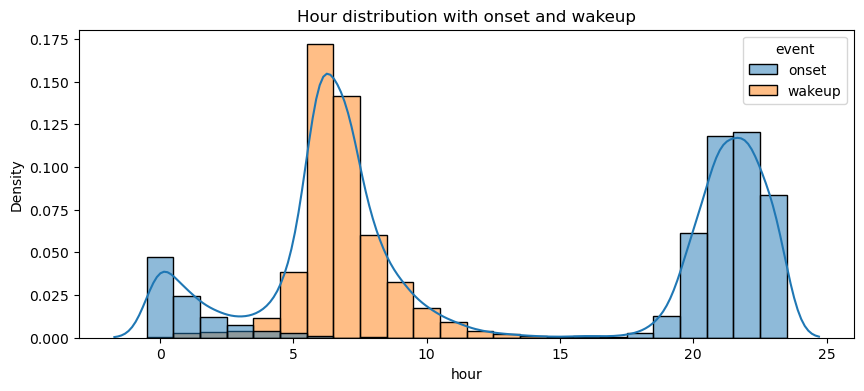

In [17]:
plt.figure(figsize=(10,4))
# plt.subplot(121)
plt.title('Hour distribution with onset and wakeup')
sns.histplot(x=train_events.dropna().hour, hue=train_events.dropna().event, stat='density', bins=24, binrange=(-0.5, 23.5))
sns.kdeplot(train_events.dropna().hour, bw_adjust=0.45)

In [25]:
train.columns

Index(['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'awake'], dtype='object')

In [26]:
signal_awake = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.208 * np.pi) ** 24))
signal_onset = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.555 * np.pi) ** 24))

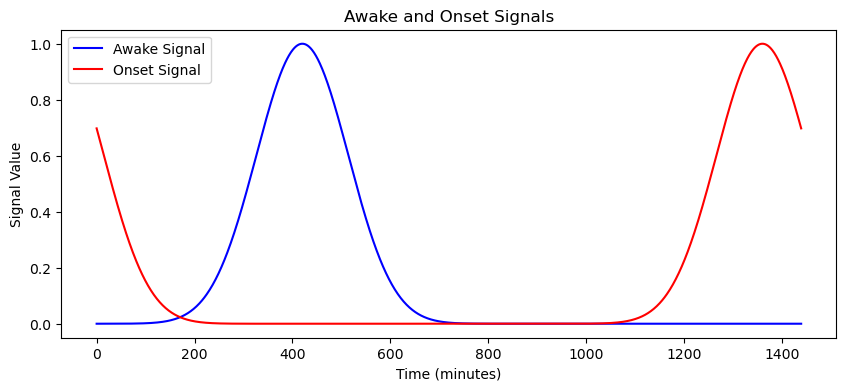

In [36]:
# Extract keys and values from the dictionaries
awake_time = list(signal_awake.keys())
awake_values = list(signal_awake.values())

onset_time = list(signal_onset.keys())
onset_values = list(signal_onset.values())

# Create line plots for both signals
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.plot(awake_time, awake_values, label='Awake Signal', color='blue')
plt.plot(onset_time, onset_values, label='Onset Signal', color='red')

# Adding labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('Signal Value')
plt.title('Awake and Onset Signals')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [37]:
train['signal_onset'] = (train.timestamp.dt.hour * 60 + train.timestamp.dt.minute).map(signal_onset).astype(np.float32)
train['signal_awake'] = (train.timestamp.dt.hour * 60 + train.timestamp.dt.minute).map(signal_awake).astype(np.float32)

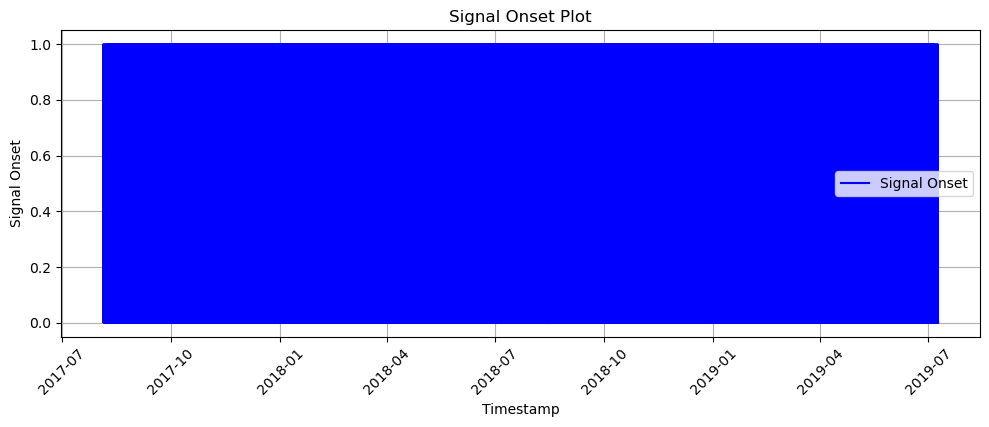

In [38]:
# Create a line plot for 'signal_onset'
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.plot(train['timestamp'], train['signal_onset'], label='Signal Onset', color='blue')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Signal Onset')
plt.title('Signal Onset Plot')

# Display the plot
plt.grid(True)  # Add grid lines
plt.legend()
plt.tight_layout()  # Ensure labels are not cut off
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()